In [23]:
%matplotlib inline
import numpy as np, pylab as plt, aipy, capo, omnical
fq = np.linspace(.1,.2,1024)
ants = np.arange(16)
antpos = np.zeros((ants.size,3)); antpos[:,0] = ants

## Simulate some data

In [40]:
# simulate unique "true" visibilities
vis_true = {}
i = 0
for j in xrange(1,ants.size):
    vis_true[j] = np.exp(2j*np.pi*10*(j-i)*fq)
# invent some gains
g = {}
for i in xrange(ants.size):
    #r = 0.4*capo.oqe.noise(1024)
    r = 0.2*capo.oqe.noise(1024)
    r[4:-3] = 0
    g[i] = 1. + np.fft.fft(r).astype(np.complex64)
# create "measured" visibilities
vis = {}
for i in xrange(ants.size):
    for j in xrange(i+1,ants.size):
        v = g[i] * np.conj(g[j]) * vis_true[j-i] + 0.0*capo.oqe.noise(1024)
        v.shape = (1,fq.size)
        vis[(i,j)] = v.astype(np.complex64)

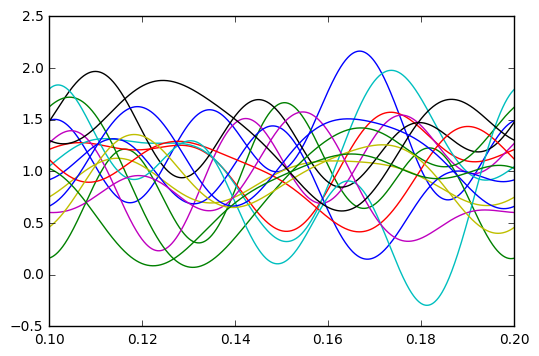

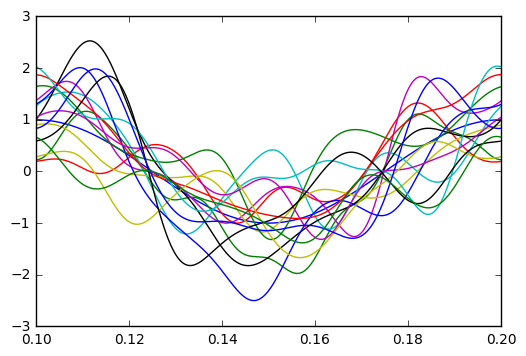

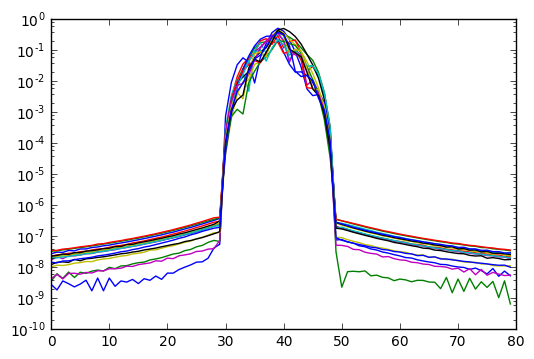

In [41]:
W = aipy.dsp.gen_window(fq.size, 'blackman-harris')
def fftplot(dat, *args, **kwargs):
    plt.semilogy(np.fft.fftshift(np.abs(np.fft.ifft(W*dat)))[512-40:512+40], *args, **kwargs)
for i in xrange(ants.size): plt.plot(fq, g[i])
plt.show()
plt.plot(fq, vis_true[1])
for i in xrange(ants.size-1): plt.plot(fq,vis[(i,i+1)][0])
plt.show()
for i in xrange(ants.size-1): fftplot(vis[(i,i+1)][0])
plt.show()

## Now build a redundant calibrator

In [42]:
reds = capo.omni.compute_reds(ants.size, 'xx', antpos)
info = omnical.info.RedundantInfo()
info.init_from_reds(reds, antpos)
g0 = {}
for i in xrange(ants.size): g0[i] = np.ones_like(g[i])


In [43]:
m1,g1,v1 = omnical.calib.redcal(vis, info, gains=g0, removedegen=True)
m2,g2,v2 = omnical.calib.redcal(vis, info, gains=g1, vis=v1, uselogcal=False, removedegen=True)
print m2['chisq']
# Fix omnical conjugation convention
for gi in [g1, g2]:
    for k in gi: gi[k] = np.conj(gi[k]).flatten()
for vi in [v1, v2]:
    for k in vi: vi[k] = vi[k].flatten()

[[  2.26859677e-11   1.44595898e-11   2.62715821e-11 ...,   1.60433437e-11
    1.93821764e-11   3.73465599e-11]]


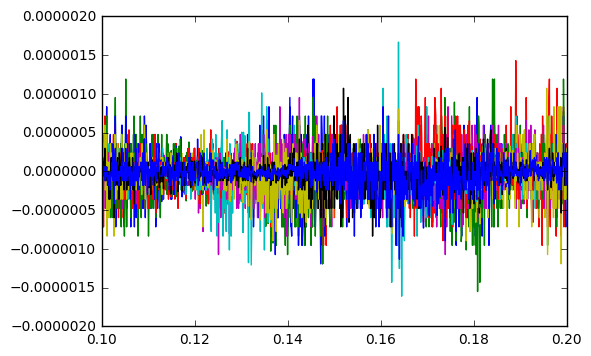

In [32]:
# demonstrate accuracy of results
for i in xrange(ants.size-1):
    plt.plot(fq, vis[(i,i+1)][0] - (g2[i] * np.conj(g2[i+1]) * v2[(0,1)]))
plt.show()

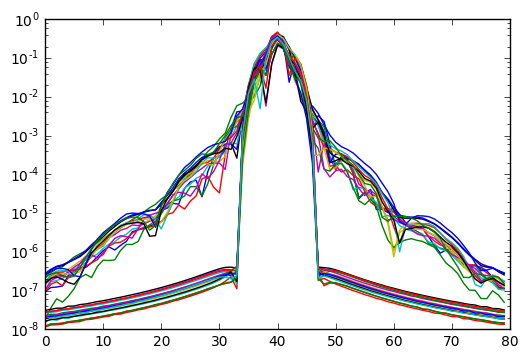

In [8]:
# check for smoothness
for i in xrange(ants.size): fftplot(g2[i])
for i in xrange(ants.size): fftplot(g[i])
plt.show()

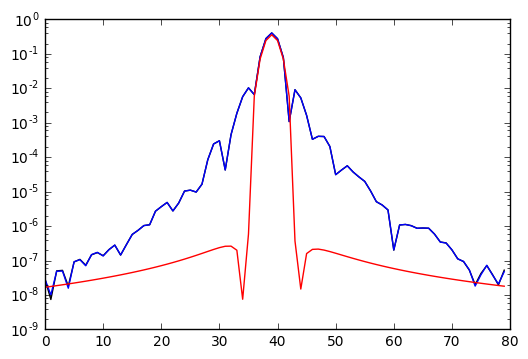

In [9]:
fftplot(v2[(0,1)], 'k')
fftplot(vis[(0,1)][0] / (g2[0] * np.conj(g2[1])), 'b')
fftplot(vis_true[1], 'r')
plt.show()

# Can we make smoother solutions?

Ok, so we have gains $g_i$ and model visibilities $\hat V$ such that $g_ig_j^*\hat V=V_{ij}$, where $V_{ij}$ is a measured visibility.  We would like to have the smoothest $\hat V$ such that this is true.

In Fourier space, $\tilde V_{ij}=\tilde g_i * \tilde g_j^* * \tilde V$.

### Let's start by using the true solutions to see if we can clean up the derived ones

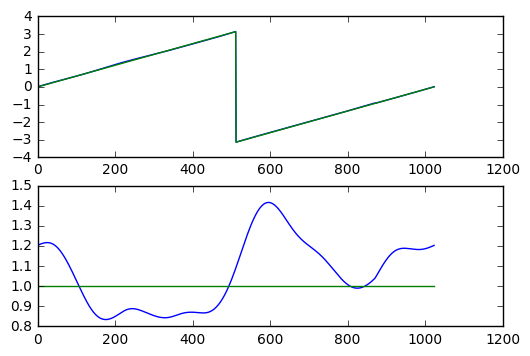

In [9]:
plt.subplot(211)
plt.plot(np.angle(v2[(0,1)]))
plt.plot(np.angle(vis_true[1]))
plt.subplot(212)
plt.plot(np.abs(v2[(0,1)]))
plt.plot(np.abs(vis_true[1]))
plt.show()

So it seems that most of the extra structure we see is in the amplitudes (not the phases), which is surprising.  Now we use ratios $V_{ij}/V$ to move spectral structure into $g_ig_j^*$.  We reassign $g_{abs}=\sqrt{V_{ij}/V}$ to each $g_i$, which takes care of amplitude structure, and divide $g_{abs}^2$ from $V$.  To handle phase structure, we project a $\phi$ gradient along the $\hat x$ direction for the factorization:
\begin{equation}
e^{\eta+i\phi}=\frac{V_{ij}}{V}
\end{equation}
We then use $\langle \frac{d\phi}{dx}\rangle$ averaged over all baseline ratios to solve for degenerate phase structure, apply the
phase structure $g_{phs}=x_i\cdot \frac{d\phi}{dx}$ to each $g_i$, and remove (divide) $(x_i-x_j)\cdot \frac{d\phi}{dx}$ from $V$.

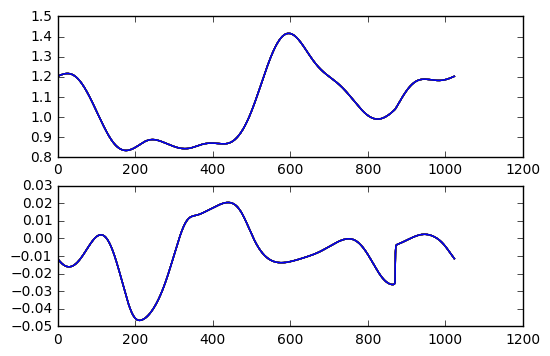

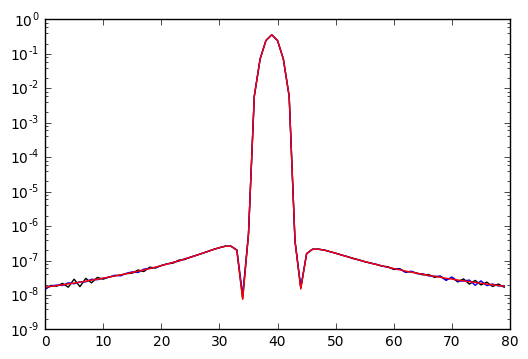

In [10]:
gabs = 0.
gphs_ew = 0.
for bl in v2:
    gabs += np.sqrt(np.abs(v2[bl]/vis_true[bl[1]-bl[0]]))
    gphs_ew += np.angle(v2[bl]/vis_true[bl[1]-bl[0]]) / (bl[0]-bl[1]) # stand in for antpos
    plt.subplot(211); plt.plot(np.abs(v2[bl]/vis_true[bl[1]-bl[0]]))
    plt.subplot(212); plt.plot(np.angle(v2[bl]/vis_true[bl[1]-bl[0]]) / (bl[0]-bl[1]))
gabs /= len(v2)
gphs_ew /= len(v2)
plt.subplot(211); plt.plot(np.abs(gabs)**2)
plt.subplot(212); plt.plot(gphs_ew)
plt.show()
g3, v3 = {}, {}
for i in g2: g3[i] = g2[i] * gabs * np.exp(1j*gphs_ew*i)
for bl in v2: v3[bl] = v2[bl] / gabs**2 / np.exp(1j*gphs_ew*(bl[0]-bl[1]))
fftplot(v3[(0,1)], 'k')
fftplot(vis[(0,1)][0] / (g3[0] * np.conj(g3[1])), 'b')
fftplot(vis_true[1], 'r')
plt.show()

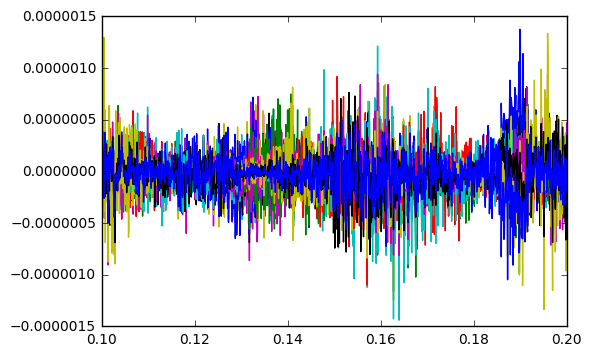

In [11]:
# demonstrate accuracy of results
for i in xrange(ants.size-1):
    plt.plot(fq, vis[(i,i+1)][0] - (g3[i] * np.conj(g3[i+1]) * v3[(0,1)]))
plt.show()

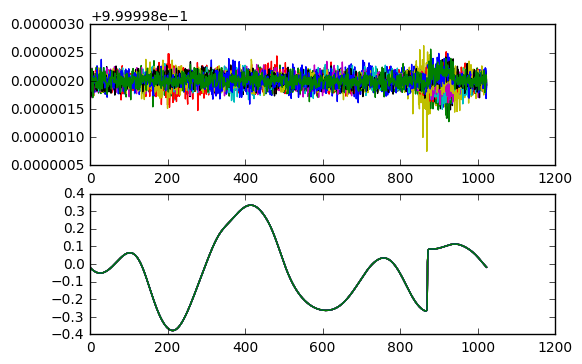

In [12]:
# check for smoothness
for i in xrange(ants.size):
    plt.subplot(211); plt.plot(np.abs(g3[i] / g[i]))
    plt.subplot(212); plt.plot(np.angle(g3[i] / g[i]))
#for i in xrange(ants.size): fftplot(g3[i])
#for i in xrange(ants.size): fftplot(g[i])
plt.show()

So the upshot here is that there is still degenerate structure, but it is in the form of an overall phase that factors our of the product $g_ig_j^*$, so it doesn't matter.  We've used our true visibilities to move spectral structure from $V$ into $g_i$, and we now have solutions for $V$ which are as smooth as the originals.

The spectral structure that we messed around with was purely degenerate, which begs the question: why wasn't it removed in the degeneracy projection applied in omnical? 

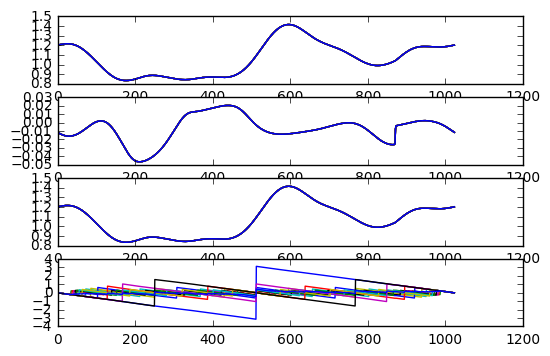

In [13]:
gabs1 = 0.
gabs2 = 0.
gphs_ew1 = 0.
gphs_ew2 = 0.
for bl in v2:
    gabs1 += np.sqrt(np.abs(v2[bl]/vis_true[bl[1]-bl[0]]))
    gabs2 += np.sqrt(np.abs(v2[bl]))
    gphs_ew1 += np.angle(v2[bl]/vis_true[bl[1]-bl[0]]) / (bl[0]-bl[1]) # stand in for antpos
    gphs_ew2 += np.angle(v2[bl]) / (bl[0]-bl[1]) # stand in for antpos
    plt.subplot(411); plt.plot(np.abs(v2[bl]/vis_true[bl[1]-bl[0]]))
    plt.subplot(412); plt.plot(np.angle(v2[bl]/vis_true[bl[1]-bl[0]]) / (bl[0]-bl[1]))
    plt.subplot(413); plt.plot(np.abs(v2[bl]))
    plt.subplot(414); plt.plot(np.angle(v2[bl]) / (bl[0]-bl[1]))
gabs1 /= len(v2)
gphs_ew1 /= len(v2)
gabs2 /= len(v2)
gphs_ew2 /= len(v2)
plt.subplot(411); plt.plot(np.abs(gabs1)**2)
plt.subplot(412); plt.plot(gphs_ew1)
plt.subplot(413); plt.plot(np.abs(gabs2)**2)
plt.subplot(414); plt.plot(gphs_ew2)
plt.show()

So that last panel might be the answer.  Without a ``true" solution, we get a bunch of phase wraps that interfere with isolating the phase degeneracy.  And it isn't about projecting structure out of the gains (which is how the current degeneracy project works). We have to project it out of the model visibilities and put it in the gains.

### Smoothing derived model visibilities using without using the truth

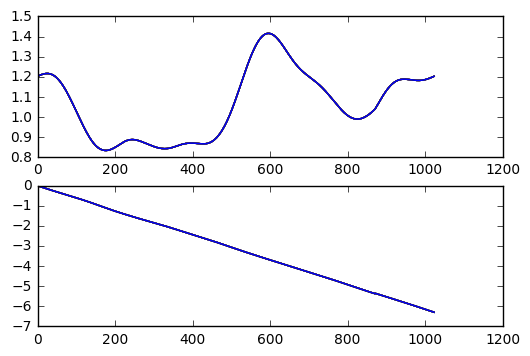

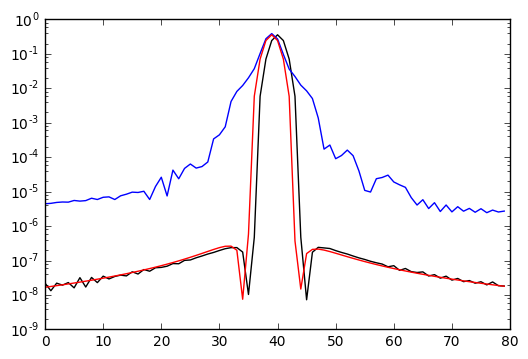

In [14]:
gabs = 0.
gphs_ew = 0.
for bl in v2:
    gabs += np.sqrt(np.abs(v2[bl]))
    gphs_ew += np.unwrap(np.angle(v2[bl])) / (bl[0]-bl[1]) # stand in for antpos
    plt.subplot(211); plt.plot(np.abs(v2[bl]))
    plt.subplot(212); plt.plot(np.unwrap(np.angle(v2[bl])) / (bl[0]-bl[1]))
gabs /= len(v2)
gphs_ew /= len(v2)
plt.subplot(211); plt.plot(np.abs(gabs)**2)
plt.subplot(212); plt.plot(gphs_ew)
plt.show()
g3, v3 = {}, {}
for i in g2: g3[i] = g2[i] * gabs * np.exp(1j*gphs_ew*i)
for bl in v2: v3[bl] = v2[bl] / gabs**2 / np.exp(1j*gphs_ew*(bl[0]-bl[1]))
fftplot(v3[(0,1)], 'k')
fftplot(v2[(0,1)], 'b')
fftplot(vis_true[1], 'r')
plt.show()

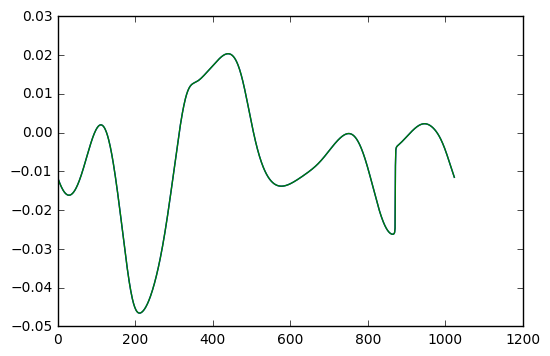

In [15]:
plt.plot(gphs_ew + np.linspace(0,2*np.pi,gphs_ew.size))
plt.plot(gphs_ew1)
plt.show()

So up to a linear phase ramp (in this case, 0 to -2$\pi$), we can recover the smooth answer by unwrapping the phase before doing the averaging over baseline.  This is a pretty easy fix for well-behaved data, but may not play nice with RFI and noisy data.  Our ability to effective deploy this may depend on how robuste a phase unwrapping function we have.  However, I think there are canned solutions that may do pretty well at this. Need to test out on real data.

# Smoothing Actual Data

In [16]:
import capo.hex
aa = aipy.cal.get_aa('hsa7458_v000_HH', np.array([.15]))
capo.hex.aa_to_info_hera(aa)
info = capo.hex.aa_to_info_hera(aa)
reds = info.get_reds()
def get_red(sep):
     for r in reds:
          if sep in r: return r

ImportError: No module named hsa7458_v000_HH

In [17]:
m,g,v,x = capo.omni.from_npz('zen.2457678.39660.yy.npz')
POL = 'yy'
print g[POL[0]].keys()
ANTS = [88,9,20,89,43]
rfi = capo.xrfi.omni_chisq_to_flags(m['chisq'])
capo.plot.waterfall(rfi, drng=1)
plt.show()

IOError: [Errno 2] No such file or directory: 'zen.2457678.39660.yy.npz'

[(9, 88), (10, 22), (10, 105)]


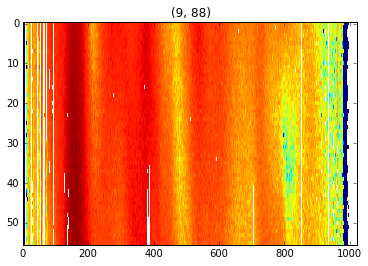

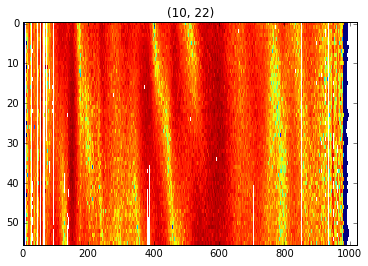

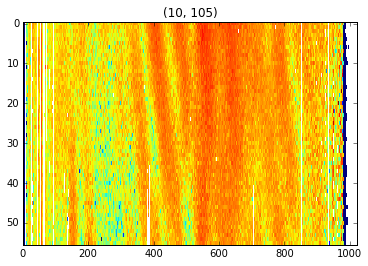

In [65]:
bls = []
for bl in [(88,i) for i in ANTS[1:-1]]:
    red = get_red(bl)
    if red is None: red = get_red(bl[::-1])
    assert(red is not None)
    for ubl in v[POL]:
        if ubl in red:
            bls.append(ubl)
            break
    if not bls[-1] == ubl: raise RuntimeError('Missing ubl for %s' % str(bl))
print bls
        
for bl in bls:
    try: vbl = v[POL][bl]
    except(KeyError):
        vbl = v[POL][bl[::-1]].conj()     
    capo.plot.waterfall(np.where(rfi,0,vbl), drng=3)
    plt.title(bl)
    plt.show()

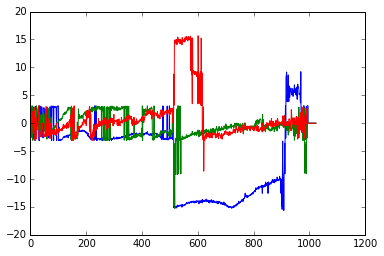

In [174]:
def unwrap(d):
    #d.shape = (-1,1)
    #capo.plot.waterfall(d*d.T.conj(), mode='phs'); plt.show()
    return np.unwrap(np.angle(d), discont=np.pi)

for bl in bls:
    try: vbl = v[POL][bl]
    except(KeyError):
        vbl = v[POL][bl[::-1]].conj()
    vbl = np.where(rfi, 0, vbl)
    wgt = np.where(rfi, 0, 1.)
    #_vbl = np.fft.ifft(vbl, axis=1)
    #mx = np.argmax(np.abs(_vbl), axis=1)
    #mx = np.where(mx > _vbl.shape[1]/2, mx-_vbl.shape[1], mx)
    #fq = np.arange(_vbl.shape[1])
    #mx.shape = (-1,1); fq.shape = (1,-1)
    dang1 = np.angle(vbl[0]) - unwrap(vbl[0])
    ddang1 = dang1[:-1] - dang1[1:]
    ddang2 = 0
    for dphs in np.linspace(0,2*np.pi,16):
        phs = np.exp(1j*dphs)
        dang2 = np.angle(vbl[0]*phs) - unwrap(vbl[0]*phs)
        ddang2 += np.abs(dang2[:-1] - dang2[1:])
    #plt.plot(ddang2)
    ddang2 = np.where(ddang2 >= 4*2*np.pi, 1, 0)
    #plt.plot((dangle1[:-1]-dangle1[1:])/(2*np.pi))
    #plt.plot(ddang1)
    #plt.plot(ddang2)
    ddang = np.where(ddang2 == 0, ddang1, 0)
    dang = np.zeros_like(ddang)
    dang[512:] = np.cumsum(ddang[512:])
    dang[:512:-1] = np.cumsum(-ddang[:512:-1])
    uvbl0 = np.angle(vbl[0])
    uvbl0[1:] += dang
    #plt.plot(ddang)
    #plt.plot(dang)
    plt.plot(uvbl0)
    #for t in xrange(10):
    #    plt.plot(unwrap(vbl[t,200:900]), label=str(bl))
    #_vbl = np.fft.ifft(vbl)
    #capo.plot.waterfall(np.fft.fftshift(_vbl,axes=1)[:,500:525], drng=4)
    #plt.title(bl)
    #plt.show()
#capo.plot.waterfall(np.fft.fftshift(_wgt,axes=1)[:,500:525], drng=4)
#plt.xlim(200,300)
#plt.xlim(450,550)
plt.show()

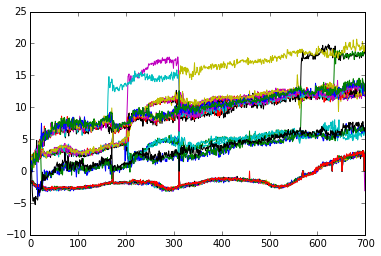

In [98]:
for cnt,bl in enumerate(bls):
    try: vbl = v[POL][bl]
    except(KeyError):
        vbl = v[POL][bl[::-1]].conj()
    vbl = np.where(rfi, 0, vbl)
    wgt = np.where(rfi, 0, 1.)
    for t in xrange(10):
        plt.plot(np.unwrap(np.angle(vbl[t,200:900]),discont=1.*np.pi), label=str(bl))
    #plt.plot(np.angle(vbl[0]))
#plt.legend()
plt.show()

In [44]:
import OmniCalibrator

ImportError: No module named OmniCalibrator